# Deep Q-Network Variant Dueling DQN implementation (PyTorch).

In this notebook, we will implement Dueling DQN variant of DQN. First part of the notebook is all about the vanilla DQN and how we train - a copy of `6.a-dqn_pytorch.ipynb`. The Dueling DQN variant is after these sections on vanilla DQN. 



### RECAP

Q Learning control is carried out by sampling step by step and updating Q values at each step. We use $\epsilon$-greedy policy to explore and generate samples. However, the policy learnt is a deterministic greedy policy with no exploration. We can carryout updates online i.e. we take a step and use `(current state, action, reward and next_state)` tuple to update.

In case of function approximation using neural network, the input to the network is the state and output is the $q(s,a)$ for all the actions in the state $s$. It is denoted as $ \hat{q}(s_t, a_t; w_{t}) $, where $w_{t}$ is the weigths of the neural network that we learn as part of DQN learning.

We use two networks, one target network with weight $w^-_t$ to get the max $q$-value of next state with best action denoted by $ \max\limits_a \hat {q}(S_{t+1},a; w^{-}_{t}) $ and network with weights $w_t^-$ which we periodically updated from primary network $w_t$.

The Update equation is given below. This is the online version:
$$ w_{t+1} \leftarrow w_t + \alpha [ R_{t+1} + \gamma . \max_{a} \hat{q}(S_{t+1},a;w^{-}_{t}) – \hat{q}(S_t,A_t;w_t)] \nabla_{w_t} \hat{q}(S_t,A_t;w_t)$$

Online update with neural network with millions of weights does not work well. Accordingly, We use experience replay (aka Replay Buffer).  We use a behavior policy to explore the environment and store the samples `(s, a, r, s', done)` in a buffer. The samples are generated using an exploratory behavior policy while we improve a deterministic target policy using q-values.

Therefore, we can always use older samples from behavior policy and apply them again and again. We can keep the buffer size fixed to some pre-determined size and keep deleting the older samples as we collect new ones. This process makes learning sample efficient by reusing a sample multiple times and also removing temporal dependence of the samples we would otherwise see while following a trajectory.

The update equation with batch update with minor modifications is given below. We collect samples of transitions `(current state, action, reward, next state)` in a buffer, where each sample is denoted as a tuple:

$$ (s_{i}, a_{i}, r_{i}, s'_{i}, done_{i})$$

Subscript ($i$) denotes ith sample. We take $N$ samples from experience replay selecting randomly and update the weights. Subscript ($t$) denotes the index of weight updates. If the current state is done, as denoted by `done` flag, the target is just the reward as terminal states have zero value. The final update equation is as given below:

$$w_{t+1} \leftarrow w_t + \alpha \frac{1}{N} \sum_{i=1}^{N} \left[ r_i + \left( (1-done_i) . \gamma .  \max_{a'} \hat{q}(s'_{i},a';w^{-}_{t}) \right) – \hat{q}(s_i,a_i;w_t) \right] \nabla_{w_t} \hat{q}(s_i,a_i;w_t)$$


#### Running in Colab/Kaggle

If you are running this on Colab, please uncomment below cells and run this to install required dependencies.

In [ ]:
## Uncomment and execute this cell to install all the the dependencies if running in Google Colab

# !apt-get update && apt-get install swig cmake ffmpeg freeglut3-dev xvfb
# !pip install box2d-py
# !pip install "stable-baselines3[extra]>=2.1"
# !pip install "huggingface_sb3>=3.0"

# !pip install git+https://github.com/DLR-RM/rl-baselines3-zoo@update/hf
# !git clone https://github.com/DLR-RM/rl-baselines3-zoo
# %cd rl-baselines3-zoo/
# !pip install -r requirements.txt
# %cd ..

### Imports

In [45]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym
import matplotlib.pyplot as plt
from scipy.signal import convolve, gaussian
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
from base64 import b64encode

from IPython.display import HTML

%matplotlib inline

### Environment - CartPole 

We can use the setup here to run on any environment which has state as a single vector and actions are discrete. We will build it on Cart Pole. Readers can try to run this on many other environments like Lunar Lander and others.

In [17]:
def make_env(env_name):
    # increase time limit from 200/500 to 4000
    env = gym.make(env_name, render_mode="rgb_array", max_episode_steps=4000)
    return env

state shape:(4,)
Number of Actions:2


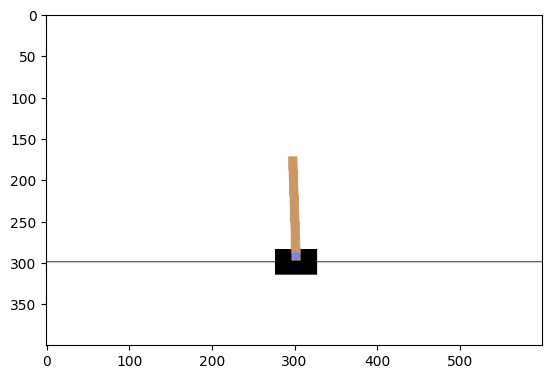

In [18]:
env_name = 'CartPole-v1'
seed=123

env = make_env(env_name)
env.reset(seed=seed)
plt.imshow(env.render())
state_shape, n_actions = env.observation_space.shape, env.action_space.n
print(f"state shape:{state_shape}\nNumber of Actions:{n_actions}")

### Building a network using pytorch

Let us build a DQN agent using a simple network. We now need to build a neural network that can map states/observations to state q-values. The observation space and action space is as given below for CartPole

    Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf
    Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right
        

The model will be a simple one with 2 hidden payers with Relu activation and final layer being logits with dimension equation to number of actions. 

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [20]:
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape

        state_dim = state_shape[0]
        # a simple NN with state_dim as input vector (input is state s)
        # and self.n_actions as output vector of logits of q(s, a)
        self.network = nn.Sequential()
        self.network.add_module('layer1', nn.Linear(state_dim, 256))
        self.network.add_module('relu1', nn.ReLU())
        self.network.add_module('layer2', nn.Linear(256, 256))
        self.network.add_module('relu2', nn.ReLU())
        self.network.add_module('layer3', nn.Linear(256, n_actions))
        #
        self.parameters = self.network.parameters

    def forward(self, state_t):
        # pass the state at time t through the network to get Q(s,a)
        qvalues = self.network(state_t)
        return qvalues

    def get_qvalues(self, states):
        # input is an array of states in numpy and output is Qvals as numpy array
        states = torch.tensor(np.array(states), device=device, dtype=torch.float32)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def get_action(self, states):
        states = torch.tensor(np.array(states), device=device, dtype=torch.float32)
        qvalues = self.forward(states)
        best_actions = qvalues.argmax(axis=-1)
        return best_actions

    def sample_actions(self, qvalues):
        # sample actions from a batch of q_values using epsilon greedy policy
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

    def save(self, path):
        print("path:",path)
        torch.save(self.network.state_dict(), f"{path}.zip")

In [21]:
agent = DQNAgent(state_shape, n_actions, epsilon=0.5).to(device)

In [22]:
agent

DQNAgent(
  (network): Sequential(
    (layer1): Linear(in_features=4, out_features=256, bias=True)
    (relu1): ReLU()
    (layer2): Linear(in_features=256, out_features=256, bias=True)
    (relu2): ReLU()
    (layer3): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [23]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    rewards = []
    for _ in range(n_games):
        s,_ = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, termiated, truncated,_ = env.step(action)
            reward += r
            if termiated:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [24]:
print(evaluate(env, agent, n_games=1))
env.close()

15.0


### Experience replay

We will use the replay buffer we saw in chapter 4 listings. Replay buffer is very important in DQN to break the correlation between samples. We use a behavior policy ($\epsilon$-greedy) to sample from the environment and store the transitions `(s,a,r,s',done)` into a buffer. These samples are used multiple times in a learning making the process sample efficient.

The interface to ReplayBuffer is:
* `exp_replay.add(state, action, reward, next_state, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns states, actions, rewards, next_states and done_flags for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

We have modified the implementation a bit to make it more efficient

In [25]:
class ReplayBuffer:
    def __init__(self, size):
        self.size = size #max number of items in buffer
        self.buffer =[] #array to hold buffer
        self.next_id = 0

    def __len__(self):
        return len(self.buffer)

    def add(self, state, action, reward, next_state, done):
        item = (state, action, reward, next_state, done)
        if len(self.buffer) < self.size:
           self.buffer.append(item)
        else:
            self.buffer[self.next_id] = item
        self.next_id = (self.next_id + 1) % self.size

    def sample(self, batch_size):
        idxs = np.random.choice(len(self.buffer), batch_size)
        samples = [self.buffer[i] for i in idxs]
        states, actions, rewards, next_states, done_flags = list(zip(*samples))
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(done_flags)

In [26]:
def play_and_record(start_state, agent, env, exp_replay, n_steps=1):

    s = start_state
    sum_rewards = 0

    # Play the game for n_steps and record transitions in buffer
    for _ in range(n_steps):
        qvalues = agent.get_qvalues([s])
        a = agent.sample_actions(qvalues)[0]
        next_s, r, terminated, truncated, _ = env.step(a)
        sum_rewards += r
        done = terminated or truncated
        exp_replay.add(s, a, r, next_s, done)
        if done:
            s,_ = env.reset()
        else:
            s = next_s

    return sum_rewards, s

#### Target network


In [27]:
target_network = DQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

### Learning with DQN
Here we write a function similar to tabular q-learning. We will calculate average TD error per batch using the equation:

$$ L =  \frac{1}{N} \sum_{i=1}^{N} \left[ r_i + \left( (1-done_i) . \gamma .  \max_{a'} \hat{q}(s'_i,a';w^-_t) \right) – \hat{q}_{w_t}(s_i,a_i;w_t) \right]^2$$


$$ \nabla_{w_t} L =   - \frac{1}{N} \sum_{i=1}^{N} \left[ r_i + \left( (1-done_i) . \gamma .  \max_{a'} \hat{q}(s'_i,a';w^-_t) \right) – \hat{q}(s_i,a_i;w_t) \right] \nabla \hat{q}_{w_t}(s_i,a_i;w_t)$$


$\hat{q}(s',a';w^{-})$ is calculated using target network whose weights are held constant and refreshed periodically from the agent learning network.

Target is given by following:
* non terminal state: $r_i +  \gamma .  \max\limits_{a'} \hat{q}(s'_i,a';w^-_t)$
* terminal state: $ r_i $

We then carryout back propagation through the agent network to update the weights using equation below:


$$
w_{t+1} \leftarrow w_t - \alpha . \nabla_{w_t}L$$

In [36]:
def td_loss_dqn(agent, target_network, states, actions, rewards, next_states, done_flags,
                    gamma=0.99, device=device):

    # convert numpy array to torch tensors
    states = torch.tensor(states, device=device, dtype=torch.float)
    actions = torch.tensor(actions, device=device, dtype=torch.long)
    rewards = torch.tensor(rewards, device=device, dtype=torch.float)
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    done_flags = torch.tensor(done_flags.astype('float32'),device=device,dtype=torch.float)

    # get q-values for all actions in current states
    # use agent network
    predicted_qvalues = agent(states)

    # compute q-values for all actions in next states
    # use target network
    predicted_next_qvalues = target_network(next_states)

    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[range(
        len(actions)), actions]

    # compute Qmax(next_states, actions) using predicted next q-values
    next_state_values,_ = torch.max(predicted_next_qvalues, dim=1)

    # compute "target q-values"
    target_qvalues_for_actions = rewards + gamma * next_state_values * (1-done_flags)

    # mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions -
                       target_qvalues_for_actions.detach()) ** 2)

    return loss

In [29]:
def epsilon_schedule(start_eps, end_eps, step, final_step):
    return start_eps + (end_eps-start_eps)*min(step, final_step)/final_step

def smoothen(values):
    kernel = gaussian(100, std=100)
    kernel = kernel / np.sum(kernel)
    return convolve(values, kernel, 'valid')

### Main Loop

We now carryout the training on DQN setup above.

In [30]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

#### Set up Environment and Policy

In [31]:
#setup env and agent and target networks
env_name = 'CartPole-v1'
env = make_env(env_name)
state_dim = env.observation_space.shape
n_actions = env.action_space.n
state,_ = env.reset(seed=seed)

agent = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

#### Train agent function

In [32]:
def train_agent(env, agent, target_network, optimizer, td_loss_fn):
    
    state, _  = env.reset(seed=seed)
    # let us fill experience replay with some samples using full random policy
    exp_replay = ReplayBuffer(10**4)
    for i in range(100):
        play_and_record(state, agent, env, exp_replay, n_steps=10**2)
        if len(exp_replay) == 10**4:
            break
    print('Finished filling buffer with: {} samples'.format(len(exp_replay)))

    mean_rw_history = []
    td_loss_history = []
    state, _ = env.reset(seed=seed)
    for step in trange(total_steps + 1):

        # reduce exploration as we progress
        agent.epsilon = epsilon_schedule(start_epsilon, end_epsilon, step, eps_decay_final_step)

        # take timesteps_per_epoch and update experience replay buffer
        _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

        # train by sampling batch_size of data from experience replay
        states, actions, rewards, next_states, done_flags = exp_replay.sample(batch_size)


        # loss = <compute TD loss>
        optimizer.zero_grad()
        loss = td_loss_fn(agent, target_network, 
                          states, actions, rewards, next_states, done_flags,                  
                          gamma=0.99,
                          device=device)

        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
        optimizer.step()

        if step % loss_freq == 0:
            td_loss_history.append(loss.data.cpu().item())

        if step % refresh_target_network_freq == 0:
            # Load agent weights into target_network
            target_network.load_state_dict(agent.state_dict())

        if step % eval_freq == 0:
            # eval the agent
            mean_rw_history.append(evaluate(
                make_env(env_name), agent, n_games=3, greedy=True, t_max=1000)
            )

            clear_output(True)
            print("buffer size = %i, epsilon = %.5f" %
                  (len(exp_replay), agent.epsilon))

            plt.figure(figsize=[16, 5])
            plt.subplot(1, 2, 1)
            plt.title("Mean return per episode")
            plt.plot(mean_rw_history)
            plt.grid()

            assert not np.isnan(td_loss_history[-1])
            plt.subplot(1, 2, 2)
            plt.title("TD loss history (smoothened)")
            plt.plot(smoothen(td_loss_history))
            plt.grid()

            plt.show()

#### Setup Training Parameters

In [34]:
#setup some parameters for training
timesteps_per_epoch = 1
batch_size = 32
total_steps = 3 * 10**4

# set exploration epsilon 
start_epsilon = 1
end_epsilon = 0.05
eps_decay_final_step = 2 * 10**4

# setup some frequency for logging and updating target network
loss_freq = 50
refresh_target_network_freq = 100
eval_freq = 1000

# to clip the gradients
max_grad_norm = 5000

#set up random numbers
seed=0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) 

#init environment
env_name = 'CartPole-v1'
env = make_env(env_name)
state_dim = env.observation_space.shape
n_actions = env.action_space.n

#init agent, target network and Optimizer
agent = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network.load_state_dict(agent.state_dict())
optimizer = torch.optim.Adam(agent.parameters(), lr=1e-4)

buffer size = 10000, epsilon = 0.05000


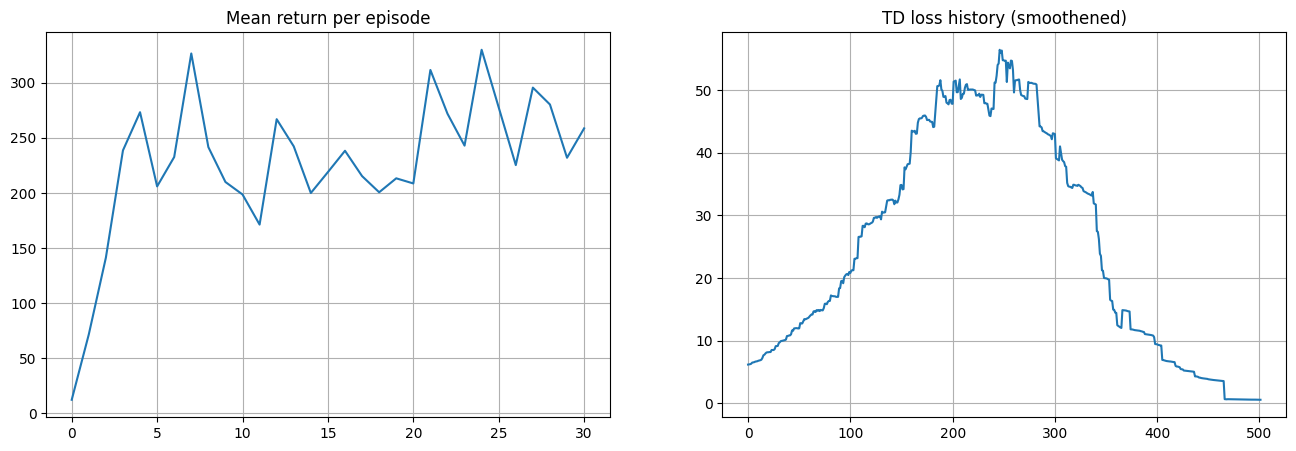

100%|████████████████████████████████████████████████████████████████████████████| 30001/30001 [02:42<00:00, 185.14it/s]


In [37]:
train_agent(env, agent, target_network, optimizer, td_loss_fn=td_loss_dqn)

In [38]:
final_score = evaluate(
  make_env(env_name),
  agent, n_games=30, greedy=True, t_max=1000
)
print('final score:', final_score)
print('Well done')

final score: 310.8
Well done


### Record and Play a video of trained agent

**Let us record a video of trained agent**

In [39]:
# Helper function to record videos
def record_video(env_id, video_folder, video_length, agent):

    vec_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array")])
    # Record the video starting at the first step
    vec_env = VecVideoRecorder(vec_env, video_folder,
                           record_video_trigger=lambda x: x == 0, video_length=video_length,
                           name_prefix=f"{type(agent).__name__}-{env_id}")

    obs = vec_env.reset()
    for _ in range(video_length + 1):
        action = agent.get_action(obs).detach().cpu().numpy()
        obs, _, _, _ = vec_env.step(action)
    # video filename
    file_path = "./"+video_folder+vec_env.video_recorder.path.split("/")[-1]
    # Save the video
    vec_env.close()
    return file_path

def play_video(file_path):
    mp4 = open(file_path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
        <video width=400 controls>
              <source src="%s" type="video/mp4">
        </video>
        """ % data_url)

In [40]:
video_folder = "logs/7_c/"
video_length = 500

video_file = record_video(env_name, video_folder, video_length, agent)

play_video(video_file)

Saving video to /home/nsanghi/sandbox/apress/drl-2ed/chapter7/logs/7_c/DQNAgent-CartPole-v1-step-0-to-step-500.mp4
Moviepy - Building video /home/nsanghi/sandbox/apress/drl-2ed/chapter7/logs/7_c/DQNAgent-CartPole-v1-step-0-to-step-500.mp4.
Moviepy - Writing video /home/nsanghi/sandbox/apress/drl-2ed/chapter7/logs/7_c/DQNAgent-CartPole-v1-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /home/nsanghi/sandbox/apress/drl-2ed/chapter7/logs/7_c/DQNAgent-CartPole-v1-step-0-to-step-500.mp4


## Dueling DQN

In this approach as discussed in paper, https://arxiv.org/pdf/1511.06581.pdf , we replace the network. Our DQN and DDQN network was predicting Q values for all the actions in a given state. Instead of that, we will now predict two separate values, one for V(s), a scalar value and A(s,a) - advantage of a given action over V(s). Using these two, Q(s,a) is computed as below:

$$ Q(s,a) = V(s) + [A(s,a) - \frac{1}{|a|} \sum_{a} A(s,a)] $$

![Dueling DQN](./images/dueling_network.png "Dueling DQN")

Training can be performed using either vanilla DQN or using DDQN approach. For demonstration purposes we will stick to vanilla DQN approach 

Code of Dueling DQN and associated code for training is given following cells

In [41]:
class DuelingDQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape
        
        state_dim = state_shape[0]
        # a simple NN with state_dim as input vector (input is state s)
        # and self.n_actions as output vector of logits of q(s, a)
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc_value = nn.Linear(128, 32)
        self.fc_adv = nn.Linear(128, 32)
        self.value = nn.Linear(32, 1)
        self.adv = nn.Linear(32, n_actions)
                
    def forward(self, state_t):
        # pass the state at time t through the network to get Q(s,a)
        x = F.relu(self.fc1(state_t))
        x = F.relu(self.fc2(x))
        v = F.relu(self.fc_value(x))
        v = self.value(v)
        adv = F.relu(self.fc_adv(x))
        adv = self.adv(adv)
        adv_avg = torch.mean(adv, dim=1, keepdim=True)
        qvalues = v + adv - adv_avg
        return qvalues

    def get_qvalues(self, states):
        # input is an array of states in numpy and output is Qvals as numpy array
        states = torch.tensor(states, device=device, dtype=torch.float32)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def get_action(self, states):
        states = torch.tensor(np.array(states), device=device, dtype=torch.float32)
        qvalues = self.forward(states)
        best_actions = qvalues.argmax(axis=-1)
        return best_actions
    
    def sample_actions(self, qvalues):
        # sample actions from a batch of q_values using epsilon greedy policy
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [43]:
#setup some parameters for training
timesteps_per_epoch = 1
batch_size = 32
total_steps = 3 * 10**4

# set exploration epsilon 
start_epsilon = 1
end_epsilon = 0.05
eps_decay_final_step = 2 * 10**4

# setup some frequency for logging and updating target network
loss_freq = 50
refresh_target_network_freq = 100
eval_freq = 1000

# to clip the gradients
max_grad_norm = 5000

#set up random numbers
seed=0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) 

#init environment
env_name = 'CartPole-v1'
env = make_env(env_name)
state_dim = env.observation_space.shape
n_actions = env.action_space.n

#init agent, target network and Optimizer
agent = DuelingDQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network = DuelingDQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network.load_state_dict(agent.state_dict())
optimizer = torch.optim.Adam(agent.parameters(), lr=1e-4)

buffer size = 10000, epsilon = 0.05000


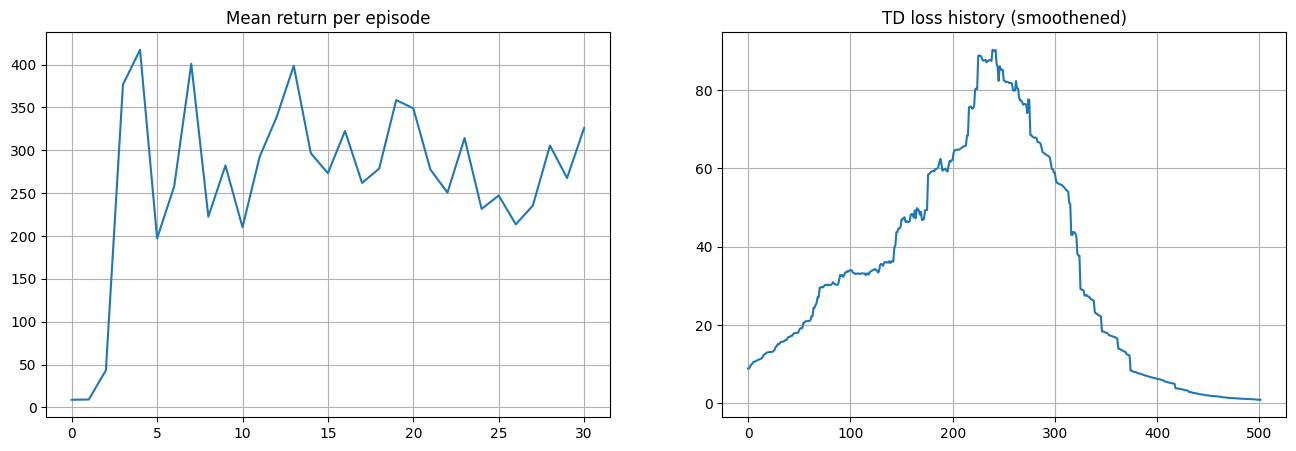

100%|████████████████████████████████████████████████████████████████████████████| 30001/30001 [02:47<00:00, 179.08it/s]


In [46]:
train_agent(env, agent, target_network, optimizer, td_loss_fn=td_loss_dqn)

In [47]:
final_score = evaluate(
  make_env(env_name),
  agent, n_games=30, greedy=True, t_max=1000
)
print('final score:', final_score)
print('Well done')

final score: 274.3333333333333
Well done


**Let us record a video of trained agent**

In [48]:
video_file = record_video(env_name, video_folder, video_length, agent)

play_video(video_file)

Saving video to /home/nsanghi/sandbox/apress/drl-2ed/chapter7/logs/7_c/DuelingDQNAgent-CartPole-v1-step-0-to-step-500.mp4
Moviepy - Building video /home/nsanghi/sandbox/apress/drl-2ed/chapter7/logs/7_c/DuelingDQNAgent-CartPole-v1-step-0-to-step-500.mp4.
Moviepy - Writing video /home/nsanghi/sandbox/apress/drl-2ed/chapter7/logs/7_c/DuelingDQNAgent-CartPole-v1-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /home/nsanghi/sandbox/apress/drl-2ed/chapter7/logs/7_c/DuelingDQNAgent-CartPole-v1-step-0-to-step-500.mp4


### Summary

In this notebook we saw how to train a DDQN agent with experience replay and target networks. As discussed above, we could also combine DDQN with Dueling type of architecture giving us **Dueling DDQN.**
